In [1]:
# Notebook https://www.kaggle.com/code/azazurrehmanbutt/cicids-ids-2018-using-cnn
# This notebook can use GPU (needs rapids dataset) 
import os 

cwd = os.path.dirname(os.path.realpath('__file__'))
inputs = cwd + "/inputs/"
if not os.path.isdir(inputs):
    os.mkdir(inputs)
outputs = cwd + "/outputs/"
if not os.path.isdir(outputs):
    os.mkdir(outputs)

inf = [f for f in os.listdir(inputs) if os.path.isfile(os.path.join(inputs, f))]
print(inf)

['02-14-2018.csv', '02-15-2018.csv', '02-20-2018.csv', '02-21-2018.csv', '03-01-2018.csv', '03-02-2018.csv', '02-23-2018.csv', '02-22-2018.csv', '02-16-2018.csv', '02-28-2018.csv']


In [2]:
# import libraries
import numpy as np
import pandas as pd 
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #EXTRA
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [3]:
# In case dataset is not downloaded 
# = *.csv not present in the inputs dir (shouldn't happen)
# = rapids.* not present in the inputs dir (just for GPU usage)
# do the following:
#
# Install kaggle (pip3 or pip)
# pip3 install kaggle
#
# Download dataset to the workdir of Sentiment-IMDB
# kaggle datasets download solarmainframe/ids-intrusion-csv
#
# Untar downloaded dataset to inputs dir
# tar -xvf ids-intrusion-csv.zip -C inputs
#
# Download RAPIDS in case of GPU
# kaggle datasets dowload cdeotte/rapids

In [4]:
%%time
# load the data into memory
network_data = pd.read_csv(inputs + '02-14-2018.csv')

CPU times: user 2.53 s, sys: 544 ms, total: 3.07 s
Wall time: 3.15 s


In [5]:
# EDA
network_data.shape


(1048575, 80)

In [6]:
# check the number of rows and columns
print('Number of Rows (Samples): %s' % str((network_data.shape[0])))
print('Number of Columns (Features): %s' % str((network_data.shape[1])))

Number of Rows (Samples): 1048575
Number of Columns (Features): 80


In [7]:
network_data.head(4)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [8]:
network_data.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [9]:
print('Total columns in our data: %s' % str(len(network_data.columns)))


Total columns in our data: 80


In [10]:
network_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [11]:
network_data['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

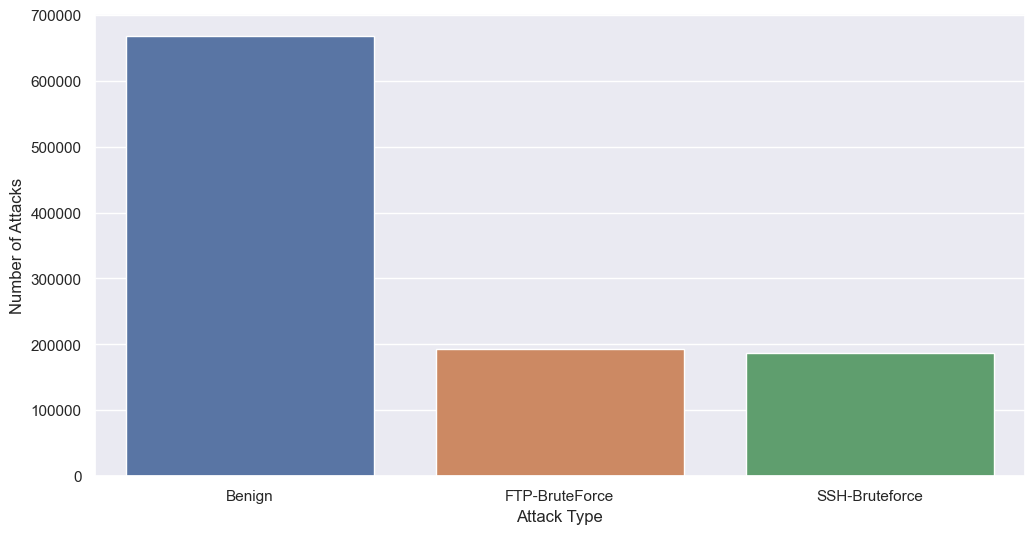

In [12]:
# Visual
# make a plot number of labels
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=network_data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

CPU times: user 527 ms, sys: 36.4 ms, total: 563 ms
Wall time: 549 ms


<Axes: xlabel='Bwd Pkts/s', ylabel='Fwd Seg Size Min'>

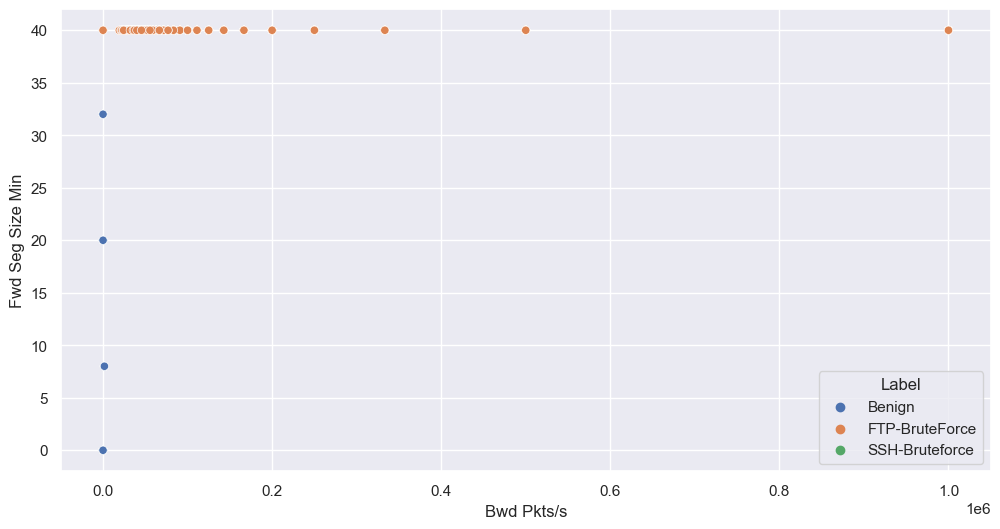

In [13]:
%%time
sns.set(rc={'figure.figsize':(12, 6)})
sns.scatterplot(x=network_data['Bwd Pkts/s'][:50000], y=network_data['Fwd Seg Size Min'][:50000], 
                hue='Label', data=network_data)

In [14]:
# Preprocess
network_data.isna().sum().to_numpy()


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2277,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [15]:
# drop null or missing columns
cleaned_data = network_data.dropna()
cleaned_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# Encoding
# The Label feature in the data contains 3 labels as Benign, BruteForceFTP and BruteForceSSH (all string).
# For NN, we need to convert them into numbers so that NN may understand their representations.
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()

/var/folders/t3/9qgt2qk56hd4rty5y8_5pj4w0000gn/T/ipykernel_49070/2795805351.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0, 1, 2])

In [17]:
cleaned_data['Label'].value_counts()


0    665355
1    193354
2    187589
Name: Label, dtype: int64

In [18]:
# Shaping the data for CNN
# make 3 seperate datasets for 3 feature labels
data_1 = cleaned_data[cleaned_data['Label'] == 0]
data_2 = cleaned_data[cleaned_data['Label'] == 1]
data_3 = cleaned_data[cleaned_data['Label'] == 2]

# make benign feature
y_1 = np.zeros(data_1.shape[0])
y_benign = pd.DataFrame(y_1)

# make bruteforce feature
y_2 = np.ones(data_2.shape[0])
y_bf = pd.DataFrame(y_2)

# make bruteforceSSH feature
y_3 = np.full(data_3.shape[0], 2)
y_ssh = pd.DataFrame(y_3)

# merging the original dataframe
X = pd.concat([data_1, data_2, data_3], sort=True)
y = pd.concat([y_benign, y_bf, y_ssh], sort=True)

In [19]:
y_1, y_2, y_3


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [20]:
print(X.shape)
print(y.shape)

(1046298, 80)
(1046298, 1)


In [21]:
X.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
# Data Augmentation - Remove Bias
from sklearn.utils import resample

data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)

In [23]:
train_dataset = pd.concat([data_1_resample, data_2_resample, data_3_resample])
train_dataset.head(2)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
659775,53,17,14/02/2018 03:29:35,79333,2,2,66,254,33,33,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
409094,443,6,14/02/2018 10:03:30,621591,9,8,1542,4796,1157,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


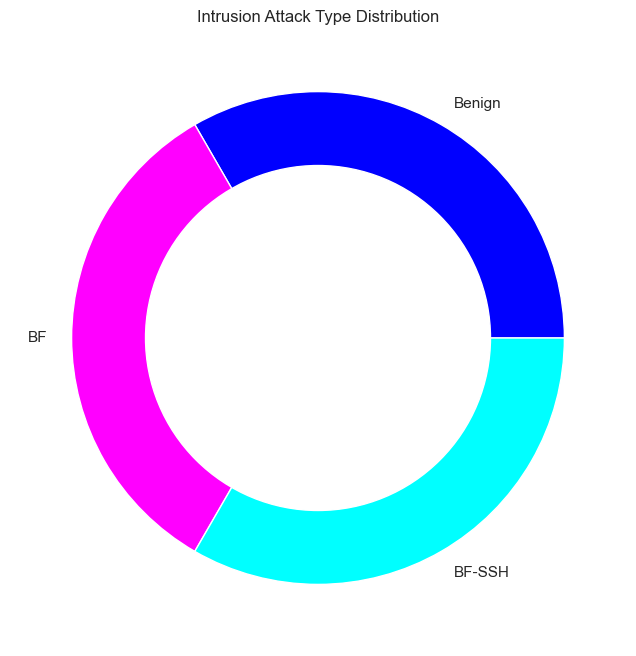

In [24]:
# viewing the distribution of intrusion attacks in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.title('Intrusion Attack Type Distribution')
plt.pie(train_dataset['Label'].value_counts(), labels=['Benign', 'BF', 'BF-SSH'], colors=['blue', 'magenta', 'cyan'])
p = plt.gcf()
p.gca().add_artist(circle)

In [25]:
# Making X & Y Variables (CNN)
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

(array([0, 1, 2]), array([0, 1, 2]))

In [26]:
y_train = to_categorical(target_train, num_classes=3)
y_test = to_categorical(target_test, num_classes=3)

In [27]:
# Data Splicing
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

In [28]:
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test

array([[4.450000e+02, 1.360587e+06, 7.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.100000e+01, 2.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.100000e+01, 1.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.200000e+01, 7.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.100000e+01, 3.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.100000e+01, 8.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 72)
(6000, 72)
(60000, 3)
(6000, 3)


In [30]:
# reshape the data for CNN
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((60000, 72, 1), (6000, 72, 1))

In [31]:
# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 72, 64)            448       
                                                                 
 batch_normalization (BatchN  (None, 72, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                        

In [38]:
# 30 - accuraccy ~60%
# 50 - accuraccy ~72%
# 70 - accuraccy ~32%
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 10.4480 - val_accuracy: 0.3193
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 11.8865 - val_accuracy: 0.3193
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 1.8550 - val_accuracy: 0.5882
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.0403 - val_accuracy: 0.5973
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 37.5722 - val_accuracy: 0.3193
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 39.6839 - val_accuracy: 0.3193
Epoch 7/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 14.8743 - val_accu

In [39]:
# Visualization of Results
# check the model performance on test data
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

188/188 [==============================] - 0s 1ms/step - loss: 1.9211 - accuracy: 0.7187
accuracy: 71.87%


In [40]:
# check history of model
history = his.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

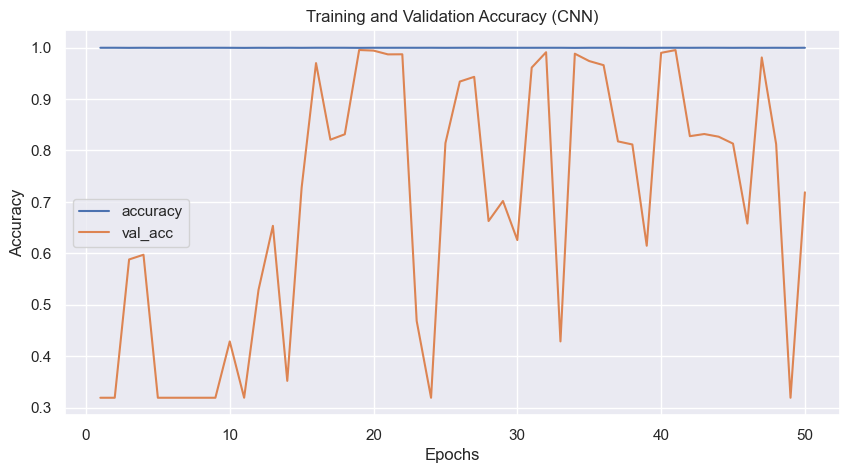

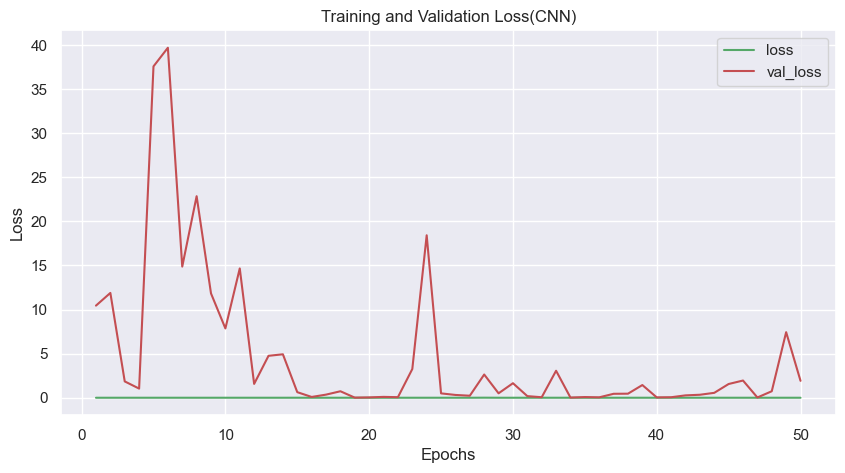

In [41]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
# Conclusion after CNN Training¶
# After training our deep CNN model on training data and validating it on validation data, it can be interpreted that:

# Model was trained on 50 epochs and then on 30 epochs
# CNN performed exceptionally well on training data and the accuracy was 99%
# Model accuracy was down to 83.55% on valiadtion data after 50 iterations, and gave a good accuracy of 92% after 30 iterations. 
# Thus, it can be interpreted that optimal number of iterations on which this model can perform are 30.